# Selection of the optimal m for correlated features

Assumption $2.4$ (Correlated features). $\Sigma$ is a deterministic positive definite matrix, and there exists constants $C_0, C_1$ satisfying $0<C_0 \leq \lambda_{\min }(\Sigma) \leq \lambda_{\min }(\Sigma) \leq C_1$ for all $n, p$. Define the empirical spectral distribution (ESD) of $\Sigma$ as $F^{\Sigma}(x)=\frac{1}{p} \sum_{i=1}^p \mathbb{1}\left\{\lambda_i(\Sigma) \leq x\right\}$. Assume that as $p \rightarrow \infty$, the ESD $F^{\Sigma}$ converges weakly to a probability measure $H$.

In [1]:
from sklearn.base import RegressorMixin
from scipy.stats import ortho_group # orthogonal matrix
from scipy.optimize import fsolve   # solve function

import numpy as np
import math

import os 
import json
import codecs

from joblib import Parallel, delayed

import seaborn as sns
import scienceplots
import matplotlib.pyplot as plt 

In [ ]:
from scipy.fftpack import dct
import numpy as np

def generate_harr_matrix(n, p):
    if n <= p:
        return np.linalg.qr(np.random.randn(p,n))[0].T
    else:
        return np.linalg.qr(np.random.randn(p,n))[0]

def hadamard_projection(X, r):
    n, p = X.shape
    X_tilde = np.concatenate([X, np.zeros((n, 1))], axis=1)
    X[: int(n / 2), :] = -X[: int(n/2), :]
    np.random.shuffle(X)
    X_tilde_dct = dct(X, axis=0, norm='ortho')
    #X_tilde_dct[0, :] = X_tilde_dct[0:, ] / np.sqrt(n)
    idx_sample = np.random.choice(n, r, replace=False)
    X_tilde_sampled = X_tilde_dct[idx_sample, :p]

    return X_tilde_sampled

def generate_orthogonal_matrix(n):
    X = generate_harr_matrix(n, n)
    S = hadamard_projection(X, n)
    return S

$\Sigma=\sum_{i=1}^p \lambda_i v_i v_i^T$, we consider eigenvalues $\lambda$
- half of the $\lambda_i = 1$, and half of the $\lambda_i = 2$

In [5]:
lambda1 = list(np.ones(12) * 2) + list(np.ones(12) * 1)

## Finding the unique soltuion of $c_0$

Lemma 4.1. Under Assumption 2.4, suppose $\phi, \psi>0$ and $\phi \psi^{-1}>1$, then the following equation (4.1) has a unique negative solution with respect to $c_0$,
$$
1=\int \frac{x}{-c_0+x \psi \phi^{-1}} d H(x) .
$$
Throughout this section, we define $c_0=c_0(\phi, \psi, H)$ to be this unique negative solution.

In [6]:
def fn(c, x, phi, psi):
    sum_ = [i/(-c + i * psi / phi) for i in x]
    return np.mean(sum_) - 1

def unique_c0_op(lambda1, phi, psi, init=-4):
    c0 = fsolve(fn, args=(lambda1, phi, psi), x0=init)
    if fn(c0, lambda1, phi, psi) < 1e-7:
        return c0
    else:
        print("Specify another starting point for the optimization method")

In [7]:
def gn(c, x, phi, psi):
    sum_ = [i/(-c + i * phi) for i in x]
    return np.mean(sum_) - 1/psi

def unique_c0_up(lambda1, phi, psi, init=4):
    c0 = fsolve(gn, args=(lambda1, phi, psi), x0=init)
    if gn(c0, lambda1, phi, psi) < 1e-7:
        return c0
    else:
        print("Specify another starting point for the optimization method")

In [8]:
psi = 0.1
phi = 0.2
print(phi/psi)
lambda1 = np.ones(24)
unique_c0_op(lambda1, phi, psi, init=-1)

2.0


array([-0.5])

In [9]:
psi = 5
phi = 2
n = 400
print(phi/psi)
lambda11 =  list(np.ones(100) * 1) + list(np.ones(100) * 0)
unique_c0_up(lambda1, phi, psi, init=-1)

0.4


array([-3.])

Definition 1 (Predicted bias and variance: min-norm regression). Let $\hat{H}_n$ be the empirical distribution of eigenvalues of $\Sigma$, and $\widehat{G}_n$ the reweighted distribution as per Eq. (G) . For $\gamma \in \mathbb{R}_{>0}$, define $c_0=c_0\left(\gamma, \widehat{H}_n\right) \in \mathbb{R}_{>0}$ to be the unique non-negative solution of

$$1-\frac{1}{\phi}=\int \frac{1}{1+c_0 \phi s} d \widehat{H}_n(s)$$

## Sketched estimator

In [10]:
class SketchedRidgelessRegressor(RegressorMixin):
    """Sketched Ridgeless regression using Moore Penrose pseudoinverse."""

    def __init__(self):
        self.beta = None

    def fit(self, x, y, m, is_orthogonal=True):
        n = x.shape[0]
        p = x.shape[1]
        
        # Fixed S
        np.random.seed(1234)

        if is_orthogonal:
            S = generate_orthogonal_matrix(n)[0:m, :]
            #S = ortho_group.rvs(dim=n)[0:m, :]   # orthogonal schetching matrix
        else:
            S = np.random.normal(size=(m, n), scale=1/np.sqrt(n))    # iid schetching matrix

        sx = np.matmul(S, x)
        sy = np.matmul(S, y)

        # xxinv = np.linalg.pinv(np.matmul(sx.T, sx))
        # xy = np.matmul(sx.T, sy)
        
        Ip = np.eye(p)
        xxinv = np.linalg.inv(np.matmul(sx.T, sx)/n + 1e-9 * Ip)
        xy = np.matmul(sx.T, sy)/n
        
        self.beta = np.matmul(xxinv, xy)
        return self

    def predict(self, x):
        return np.matmul(x, self.beta)

In [11]:
class RidgelessLinearRegressor(RegressorMixin):
    """Ridgeless linear regression using Moore Penrose pseudoinverse."""

    def __init__(self):
        self.beta = None

    def fit(self, x, y):
        n = x.shape[0]
        p = x.shape[1]
        
        #xxinv = np.linalg.pinv(np.matmul(x.T, x))
        #xy = np.matmul(x.T, y)
        
        Ip = np.eye(p)
        xxinv = np.linalg.inv(np.matmul(x.T, x)/n + 1e-9 * Ip)
        xy = np.matmul(x.T, y)/n
        
        self.beta = np.matmul(xxinv, xy)
        return self

    def predict(self, x):
        return np.matmul(x, self.beta)

## Theoretical risk (Thm 4.2)

Theorem 4.2. Suppose Assumptions $2.1,2.2,2.4$ and $2.5$ hold. Suppose also that as $m, n, p \rightarrow \infty, p / n \rightarrow \phi, m / n \rightarrow \psi \in(0,1)$, and $p / m \rightarrow \phi \psi^{-1}>1$. Let $c_0$ be the unique negative solution of (4.1). Then it holds almost surely that for the bias part,
$$
\left.B_{(S, X)} \widehat{\beta^{\mathrm{S}}} ; \beta\right) \rightarrow-\alpha^2 c_0 .
$$
Besides, $\left.B_{(\beta, S, X)} \widehat{\beta^{\mathrm{S}}} ; \beta\right)$ converges almost surely to the same limit. For the variance part,
$$
V_{(\beta, S, X)}\left(\widehat{\beta}^S ; \beta\right)=V_{(S, X)}\left(\widehat{\beta}^{\mathrm{S}} ; \beta\right) \rightarrow \sigma^2 \frac{\int \frac{x^2 \psi \phi^{-1}}{\left(c_0-x \psi \phi^{-1}\right)^2} d H(x)}{1-\int \frac{x^2 \psi \phi^{-1}}{\left(c_0-x \psi \phi^{-1}\right)^2} d H(x)} .
$$
The out-of-sample prediction risks $R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$ and $R_{(\beta, S, X)}\left(\widehat{\beta}^S ; \beta\right)$ converges almost surely to the corresponding sum.

Theorem 4.3. Suppose Assumptions 2.1, 2.2, $2.4$ and $2.5$ hold. Suppose also that as $m, n, p \rightarrow \infty, p / n \rightarrow \phi, m / n \rightarrow \psi \in(0,1)$, and $p / m \rightarrow \phi \psi^{-1}<1$. Then for the bias part, it holds almost surely that
Define $\widetilde{c}_0=\widetilde{c}_0(\phi, \psi, B)$ be the unique negative solution of the following equation,
$$
1=\psi \int \frac{x}{-\widetilde{c}_0+x \phi} d B(x) .
$$
Then for the variance part, it holds almost surely that

$$
V_{(S, X)}\left(\widehat{\beta}^{\mathrm{S}} ; \beta\right)=V_{(\beta, S, X)}\left(\widehat{\beta}^{\mathrm{S}} ; \beta\right) \rightarrow \sigma^2 \frac{\psi \int \frac{x^2 \phi}{\left(\widetilde{c}_0-x \phi\right)^2} d B(x)}{1-\psi \int \frac{x^2 \phi}{\left(c_0-x \phi\right)^2} d B(x)}
$$

In [12]:
def asy_risk_sketching(n, p, m, alpha, is_orthogonal, lambda_op, sigma=1):
    """
    gamma: p/n
    psi: m/n
    norm: alpha in Lemma 3.2
    """

    phi = p / n
    psi = m / n
    
    condition = phi / psi
    condition_inv = psi / phi

    c0_op = unique_c0_op(lambda_op, phi, psi, init=-1)[0]

    if m > p and condition_inv > 1: 
        b_up = 0
        # numerator_ = psi * np.mean([i**2 * phi / (c0_up - i * phi)**2 for i in lambda_up])
        # denominator_ = 1 - psi * np.mean([i**2 * phi / (c0_up - i * phi)**2 for i in lambda_up])
        # v_up = sigma**2 * numerator_ / denominator_
        
        if is_orthogonal:
            v_up = sigma**2 * (condition / (1-condition))
        else:
            v_up = sigma**2 * (phi/(1-phi) + condition / (1-condition))
        return b_up + v_up

    if m < p and condition > 1:
        b_op = -alpha**2 * c0_op
        numerator_ = np.mean([i**2 * condition_inv / (c0_op - i * condition_inv)**2 for i in lambda_op])
        denominator_ = 1 - np.mean([i**2 * condition_inv / (c0_op - i * condition_inv)**2 for i in lambda_op])
        v_op = sigma**2 * numerator_ / denominator_
        return b_op + v_op

In [13]:
def asy_risk_no_sketching(n, p, alpha, lambda_op, sigma):
    
    phi = p / n
    
    psi = 1
    
    condition = phi / psi
    condition_inv = psi / phi

    # gamma < 1
    if phi < 1:
        return sigma**2 * phi / (1 - phi)
    
    c0_op = unique_c0_op(lambda_op, phi, psi, init=-1)[0]

    # gamma > 1
    if phi > 1:
        b_op = -alpha**2 * c0_op
        numerator_ = np.mean([i**2 * condition_inv / (c0_op - i * condition_inv)**2 for i in lambda_op])
        denominator_ = 1 - np.mean([i**2 * condition_inv / (c0_op - i * condition_inv)**2 for i in lambda_op])
        v_op = sigma**2 * numerator_ / denominator_
        return b_op + v_op

## Case 1: Orothogonal matrix

In [17]:
n_train = 400
n_test = 100

alpha = 6
sigma = 3.0
seed = 12341
n_sim = 500

n_pts = 40                 # number of points in the graph for visualizing empirical results (dots)
n_pts_asymp = 80           # number of points in the graph for visualizing theorem 3.2 (line)

In [18]:
def optimal_m(n_train, n_features, alpha, sigma, is_orthogonal, lambda_op, n_pts_asymp=100, index=0):
    # Theorem 4 
    mm = np.zeros(n_pts_asymp, dtype=int)
    mse_asy = []

    psi = list(np.linspace(0.1, 0.49, int(n_pts_asymp/2))) + list(np.linspace(0.51, 0.99, int(n_pts_asymp/2)))
    mm = [int(ppsi * n_train) for ppsi in psi]
    mse_asy = Parallel(n_jobs=-1)(delayed(asy_risk_sketching)(n_train, n_features, mm[j], alpha, is_orthogonal, lambda_op, sigma=sigma) for j in range(n_pts_asymp))
        
    # 1. Remove none or negative mse
    none_index = [i for i in range(len(mse_asy)) if mse_asy[i] == None or mse_asy[i] < 0]
    if len(none_index) > 0:
        mse_asy = np.delete(mse_asy, (np.r_[none_index]))
        psi = np.delete(psi, (np.r_[none_index]))
        mm = np.delete(mm, (np.r_[none_index]))

    # 2. Remove outliers that change dramastically 
    dx = psi[1] - psi[0]
    dy = np.diff(mse_asy) / dx
    # Find sign change
    sign_change = (np.diff(np.sign(dy)) != 0)*1
    change_index = [i for i in range(len(sign_change)) if sign_change[i] == 1]
    if len(change_index) > 0:
        mse_asy = np.delete(mse_asy, (np.r_[change_index]))
        psi = np.delete(psi, (np.r_[change_index]))
        mm = np.delete(mm, (np.r_[change_index]))
    
    # 3. If decreasing in the tail but min not attain at the end (due to numerical instability), then get m = n
    if n_train - mm[np.nanargmin(mse_asy)] < 50:
        opt_m = n_train
    else:
        opt_m = mm[np.nanargmin(mse_asy)]
    
    plt.clf()        
    ax = sns.lineplot(x=psi, y=mse_asy)
    ax.set_ylim(-2, 60)
    ax.set_title("n features: " + str(n_features) + ", optimal m: " + str(opt_m) + ", phi :" + str(n_features/n_train) + ", " + str(mse_asy[-1] - mse_asy[0]))
    ax.set_ylabel("Out-of-sample Risk")
    ax.set_xlabel(r"$\psi$ = m/n")
    plt.show()
    
    return opt_m

In [19]:
n_features = 200
mm = np.zeros(n_pts_asymp, dtype=int)
mse_asy1 = np.zeros(n_pts_asymp)

psi = list(np.linspace(0.11, 0.49, int(n_pts_asymp/2))) + list(np.linspace(0.51, 0.99, int(n_pts_asymp/2)))
for i, ppsi in enumerate(psi):
    mm[i] = int(ppsi * n_train)
    lambda_up = list(np.ones(mm[i]) * 1)  # orthogonal
    lambda_op = list(np.ones(n_features) * 2) + list(np.ones(n_features) * 1) 
    mse_asy1[i]= asy_risk_sketching(n_train, n_features, mm[i], alpha, lambda_up, lambda_op, sigma=sigma)
    
n_features = 424
mm = np.zeros(n_pts_asymp, dtype=int)
mse_asy = np.zeros(n_pts_asymp)

psi = list(np.linspace(0.11, 0.49, int(n_pts_asymp/2))) + list(np.linspace(0.51, 0.99, int(n_pts_asymp/2)))
for i, ppsi in enumerate(psi):
    mm[i] = int(ppsi * n_train)
    lambda_up = list(np.ones(mm[i]) * 1)  # orthogonal
    lambda_op = list(np.ones(n_features) * 2) + list(np.ones(n_features) * 1) 
    mse_asy[i]= asy_risk_sketching(n_train, n_features, mm[i], alpha, lambda_up, lambda_op, sigma=sigma)
    
n_features = 424
mm = np.zeros(n_pts_asymp, dtype=int)
mse_asy = np.zeros(n_pts_asymp)

psi = list(np.linspace(0.11, 0.49, int(n_pts_asymp/2))) + list(np.linspace(0.51, 0.99, int(n_pts_asymp/2)))
for i, ppsi in enumerate(psi):
    mm[i] = int(ppsi * n_train)
    lambda_up = list(np.ones(mm[i]) * 1)  # orthogonal
    lambda_op = list(np.ones(n_features) * 2) + list(np.ones(n_features) * 1) 
    mse_asy[i]= asy_risk_sketching(n_train, n_features, mm[i], alpha, lambda_up, lambda_op, sigma=sigma)

In [20]:
import matplotlib.pyplot as plt

with plt.style.context(['science', 'no-latex', 'std-colors']):
    fig, ax = plt.subplots(1, 2, figsize=(13, 4))

    ax[0] = sns.lineplot(x=psi, y=mse_asy1, ax=ax[0])
    ax[0] = sns.scatterplot(x=[1.0], y=[np.min(mse_asy1)], ax=ax[0], label = "optimal m = 400", color='orange')
    ax[0].set_ylim(-5, 100)
    ax[0].invert_xaxis()
    ax[0].set_xlabel(r"$\psi$")
    ax[0].set_title("Case 1: Orthogonal sketching matrix with p = 200")
    ax[0].set_ylabel(r"Out-of-sample prediction risk $R_{(\beta, X)}\left(\widehat{\beta}^S ; \beta\right)$")

    
    ax[1] = sns.lineplot(x=psi, y=mse_asy, ax=ax[1])
    ax[1] = sns.scatterplot(x=[psi[np.argmin(mse_asy)]], y=[np.min(mse_asy)], ax=ax[1], label = "optimal m = 247", color='orange')
    ax[1].set_ylim(-20, 70)
    ax[1].set_xlabel(r"$\psi$")
    ax[1].set_title("Case 2: Orthogonal sketching matrix with p = 424")
    ax[1].set_ylabel(r"Out-of-sample prediction risk $R_{(\beta, X)}\left(\widehat{\beta}^S ; \beta\right)$")
    ax[1].invert_xaxis()
    plt.savefig('figure5.pdf', dpi=400, facecolor='w', edgecolor='w', pad_inches=None)

#### Numerical simulations

In [13]:
def gen_correlated_train_dat(n_train, n_features, alpha, x_sigma, sigma, seed):
    """
    n_samples: n
    n_features: p
    alpha: beta's norm
    sigma: sigma
    """

    #bet = norm / np.sqrt(p) * np.ones(p) 
    
    # seed for X 
    np.random.seed(1234)
    
    # Assumption 2.4 (correlated features)
    x = np.random.multivariate_normal(mean=np.zeros(n_features), cov=x_sigma, size=(n_train))
    
    # seed for eps
    np.random.seed(seed+3524)
    # Assumption 2.2 (random beta)
    bet = alpha / np.sqrt(n_features) * np.random.normal(size=n_features)  #from guassian prior
    eps = np.random.normal(size=n_train, scale=sigma)
    y = np.matmul(x, bet) + eps

    return x, y, bet

def gen_correlated_test_dat(n_test, n_features, beta, x_sigma, sigma, seed):
    
    # seed for x0 and eps
    np.random.seed(seed+1234)
    
    x0 = np.random.multivariate_normal(mean=np.zeros(n_features), cov=x_sigma, size=(n_test))
    eps = np.random.normal(size=n_test, scale=sigma)
    y = np.matmul(x0, beta) + eps

    return x0, y

In [14]:
def simulate_no_sketching(n_train, n_features, alpha, sigma, x_sigma, seed, n_test=1):
    
    # train
    x, y, beta = gen_correlated_train_dat(n_train, n_features, alpha, x_sigma, sigma, seed)  

    # test
    x_oos, y_oos = gen_correlated_test_dat(n_test, n_features, beta, x_sigma, sigma, seed)

    # fit ridgeless least square using sketching matrix
    ridgeless = RidgelessLinearRegressor()
    ridgeless = ridgeless.fit(x, y)
    
    # calculate mse
    test_mse = np.mean((np.matmul(x_oos, ridgeless.beta) - np.matmul(x_oos, beta))**2)

    return test_mse 

def simulate_sketching(n_train, n_features, m, alpha, sigma, x_sigma, seed, is_orthogonal=True, n_test=1):
    
    # train
    x, y, beta = gen_correlated_train_dat(n_train, n_features, alpha, x_sigma, sigma, seed)  

    # test
    x_oos, y_oos = gen_correlated_test_dat(n_test, n_features, beta, x_sigma, sigma, seed)

    # fit ridgeless least square using sketching matrix
    ridgeless = SketchedRidgelessRegressor()
    ridgeless = ridgeless.fit(x, y, m, is_orthogonal)
    
    # calculate mse
    test_mse = np.mean((np.matmul(x_oos, ridgeless.beta) - np.matmul(x_oos, beta))**2)

    return test_mse 

In [ ]:
%%time
pp = np.zeros(n_pts, dtype=int)
mse_original = np.zeros(n_pts)
mse_sketch = np.zeros(n_pts)
opt_m = np.zeros(n_pts, dtype=int)

phi_range = list(np.logspace(-1, 1, n_pts))
for i, pphi in enumerate(phi_range):
    ppp = int(pphi * n_train / 2)
    pp[i] = ppp * 2
    
    lambda_op = list(np.ones(ppp) * 2) + list(np.ones(ppp) * 1) 
    opt_m[i] = optimal_m(n_train, pp[i], alpha, sigma, True, lambda_op, index=i)
    
    sigma_x = np.diag(lambda_op)
    
    # Non-sketching
    mse_oos = []
    mse_oos = Parallel(n_jobs=-1)(delayed(simulate_no_sketching)(n_train, pp[i], alpha, sigma, sigma_x, seed+j, n_test=n_test) for j in range(n_sim))
    mse_original[i] = np.mean(mse_oos)
    
    # Sketching
    mse_oos_sketch = []
    if opt_m[i] == n_train: 
        mse_sketch[i] = mse_original[i]
    else:
        mse_oos_sketch = Parallel(n_jobs=-1)(delayed(simulate_sketching)(n_train, pp[i], opt_m[i], alpha, sigma, sigma_x, seed+j, is_orthogonal=True, n_test=n_test) for j in range(n_sim)) 
        mse_sketch[i] = np.mean(mse_oos_sketch)
    
    print(pphi, opt_m[i], mse_sketch[i])

In [ ]:
import pandas as pd

df = pd.DataFrame()
df['phi_range'] = phi_range
df['mse_sketch'] = mse_sketch

## Asymptotic 

In [20]:
pp = np.zeros(n_pts_asymp, dtype=int)
mse_original = np.zeros(n_pts_asymp)

phi = list(np.logspace(-1, 1, n_pts_asymp))
for i, pphi in enumerate(phi):
    ppp = int(pphi * n_train / 2)
    pp[i] = ppp * 2
    
    lambda_op = list(np.ones(ppp) * 2) + list(np.ones(ppp) * 1) 
    mse_original[i] = asy_risk_no_sketching(n_train, pp[i], alpha, lambda_op, sigma) 

In [21]:
data = {
    "s_orthogonal": 0,
    "n_train": n_train,
    "alpha": alpha,
    "sigma": sigma,
    "seed": seed,
    "emp_phi": phi_range,
    "emp_sketch_risk": df['mse_sketch'].to_list(),
    "phi": phi,
    "ridgeless_risk": mse_original.tolist()
}

save_path = "../result/thm4.2_sym_lambda_S_orthogonal/" 
if not os.path.isdir(save_path):
    os.makedirs(save_path)

# Save
with open(save_path + 'snr' + str(alpha/sigma) + '.json', 'w') as file:
    json.dump(data, file,indent=4)

In [2]:
def load_files(file_loc):
    file = json.loads(codecs.open('../result/' + file_loc, 'r').read())
    emp_phi = file["emp_phi"]
    emp_sketch_risk = file["emp_sketch_risk"]
    
    phi = file["phi"]
    ridgeless_risk = file["ridgeless_risk"]

    return file["alpha"], file["sigma"], emp_phi, emp_sketch_risk, phi, ridgeless_risk

In [23]:
alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('thm4.2_sym_lambda_S_orthogonal/snr2.0.json')

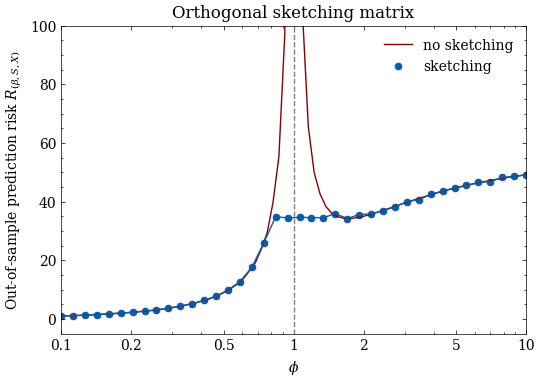

In [24]:
# Plot
ticks = [0.1, 0.2, 0.5, 1, 2, 5, 10]
labels = [i for i in ticks]

with plt.style.context(['science', 'no-latex', 'std-colors']):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    #ax = sns.scatterplot(x=emp_phi, y=emp_sketch_risk)
    ax = sns.lineplot(x=phi_asy, y=ridgeless_risk, color='darkred', label="no sketching")
    
    ax = sns.lineplot(x=emp_phi, y=emp_sketch_risk)
    ax = sns.scatterplot(x=emp_phi, y=emp_sketch_risk , label="sketching")
    ax.set_ylim(-5, 100)
    ax.set_xlim(0.1, 10)
    ax.axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
    ax.set_xscale('log')
    ax.set(xticks = ticks, xticklabels = labels)

    ax.set_title("Orthogonal sketching matrix")
    ax.set_ylabel(r"Out-of-sample prediction risk $R_{(\beta, S, X)}$")
    ax.set_xlabel(r"$\phi$")

    plt.savefig('figure4.png', dpi=400, facecolor='w', edgecolor='w', pad_inches=None)
    plt.show()

## Case 2: iid sketching matrix

In [ ]:
%%time
pp = np.zeros(n_pts, dtype=int)
mse_original = np.zeros(n_pts)
mse_sketch = np.zeros(n_pts)
opt_m = np.zeros(n_pts, dtype=int)

phi_range = list(np.logspace(-1, 1, n_pts))
for i, pphi in enumerate(phi_range):
    ppp = int(pphi * n_train / 2)
    pp[i] = ppp * 2
    
    lambda_op = list(np.ones(ppp) * 2) + list(np.ones(ppp) * 1) 
    opt_m[i] = optimal_m(n_train, pp[i], alpha, sigma, False, lambda_op, index=i)
    
    sigma_x = np.diag(lambda_op)
    
    # Non-sketching
    mse_oos = []
    mse_oos = Parallel(n_jobs=-1)(delayed(simulate_no_sketching)(n_train, pp[i], alpha, sigma, sigma_x, seed+j, n_test=n_test) for j in range(n_sim))
    mse_original[i] = np.mean(mse_oos)
    
    # Sketching
    mse_oos_sketch = []
    if opt_m[i] == n_train: 
        mse_sketch[i] = mse_original[i]
    else:
        mse_oos_sketch = Parallel(n_jobs=-1)(delayed(simulate_sketching)(n_train, pp[i], opt_m[i], alpha, sigma, sigma_x, seed+j, is_orthogonal=False, n_test=n_test) for j in range(n_sim)) 
        mse_sketch[i] = np.mean(mse_oos_sketch)
    
    print(pphi, opt_m[i], mse_sketch[i])

In [ ]:
import pandas as pd

df = pd.DataFrame()
df['phi_range'] = phi_range
df['mse_sketch'] = mse_sketch

In [ ]:
pp = np.zeros(n_pts_asymp, dtype=int)
mse_original = np.zeros(n_pts_asymp)

phi = list(np.logspace(-1, 1, n_pts_asymp))
for i, pphi in enumerate(phi):
    ppp = int(pphi * n_train / 2)
    pp[i] = ppp * 2
    
    lambda_op = list(np.ones(ppp) * 2) + list(np.ones(ppp) * 1) 

    mse_original[i] = asy_risk_no_sketching(n_train, pp[i], alpha, lambda_op, sigma=sigma)

In [ ]:
data = {
    "s_orthogonal": 0,
    "n_train": n_train,
    "alpha": alpha,
    "sigma": sigma,
    "seed": seed,
    "emp_phi": phi_range,
    "emp_sketch_risk": df['mse_sketch'].to_list(),
    "phi": phi,
    "ridgeless_risk": mse_original.tolist()
}

save_path = "../result/thm4.2_sym_lambda_S_iid/" 
if not os.path.isdir(save_path):
    os.makedirs(save_path)

# Save
with open(save_path + 'snr' + str(alpha/sigma) + '.json', 'w') as file:
    json.dump(data, file,indent=4)

In [ ]:
alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('thm4.2_sym_lambda_S_iid/snr2.0.json')

In [ ]:
# Plot
ticks = [0.1, 0.2, 0.5, 1, 2, 5, 10]
labels = [i for i in ticks]

with plt.style.context(['science', 'no-latex', 'std-colors']):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    #ax = sns.scatterplot(x=emp_phi, y=emp_sketch_risk)
    ax = sns.lineplot(x=phi_asy, y=ridgeless_risk, color='darkred', label="no sketching")
    
    ax = sns.lineplot(x=emp_phi, y=emp_sketch_risk)
    ax = sns.scatterplot(x=emp_phi, y=emp_sketch_risk , label="sketching")
    ax.set_ylim(-5, 100)
    ax.set_xlim(0.1, 10)
    ax.axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
    ax.set_xscale('log')
    ax.set(xticks = ticks, xticklabels = labels)

    ax.set_title("iid sketching matrix")
    ax.set_ylabel(r"Out-of-sample prediction risk $R_{(\beta, S, X)}$")
    ax.set_xlabel(r"$\phi$")

    plt.savefig('figure5.png', dpi=400, facecolor='w', edgecolor='w', pad_inches=None)
    plt.show()

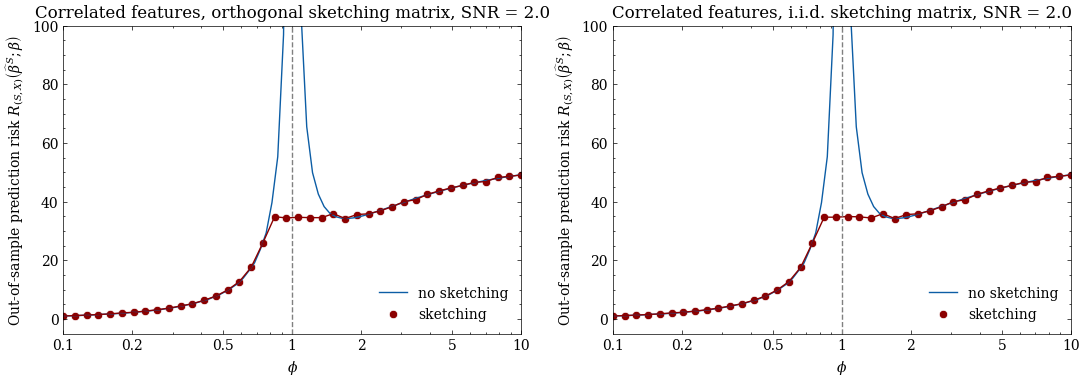

In [3]:
# Plot
ticks = [0.1, 0.2, 0.5, 1, 2, 5, 10]
labels = [i for i in ticks]

with plt.style.context(['science', 'no-latex', 'std-colors']):
    fig, ax = plt.subplots(1, 2, figsize=(13, 4))

    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('thm4.2_sym_lambda_S_orthogonal/snr2.0.json')
    ax[0] = sns.lineplot(x=phi_asy, y=ridgeless_risk, ax=ax[0], label="no sketching")
    ax[0] = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, ax=ax[0], color='darkred', label="sketching")
    ax[0] = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='darkred', ax=ax[0])


    ax[0].set_ylim(-5, 100)
    ax[0].set_xlim(0.1, 10)
    ax[0].axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
    ax[0].set_title("Correlated features, orthogonal sketching matrix, SNR = 2.0")
    ax[0].set_xscale('log')
    ax[0].set(xticks = ticks, xticklabels = labels)
    ax[0].legend(loc='lower right')

    ax[0].set_ylabel(r"Out-of-sample prediction risk $R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$")
    ax[0].set_xlabel(r"$\phi$")


    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('thm4.2_sym_lambda_S_iid/snr2.0.json')
    ax[1] = sns.lineplot(x=phi_asy, y=ridgeless_risk, ax=ax[1], label="no sketching")
    ax[1] = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, ax=ax[1], color='darkred', label="sketching")
    ax[1] = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='darkred', ax=ax[1])
    

    ax[1].set_ylim(-5, 100)
    ax[1].set_xlim(0.1, 10)
    ax[1].axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
    ax[1].set_title("Correlated features, i.i.d. sketching matrix, SNR = 2.0")
    ax[1].set_xscale('log')
    ax[1].set(xticks = ticks, xticklabels = labels)

    ax[1].set_ylabel(r"Out-of-sample prediction risk $R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$")
    ax[1].set_xlabel(r"$\phi$")
    ax[1].legend(loc='lower right')

    plt.savefig('figure4.pdf', dpi=400, facecolor='w', edgecolor='w', pad_inches=None)
    plt.show()

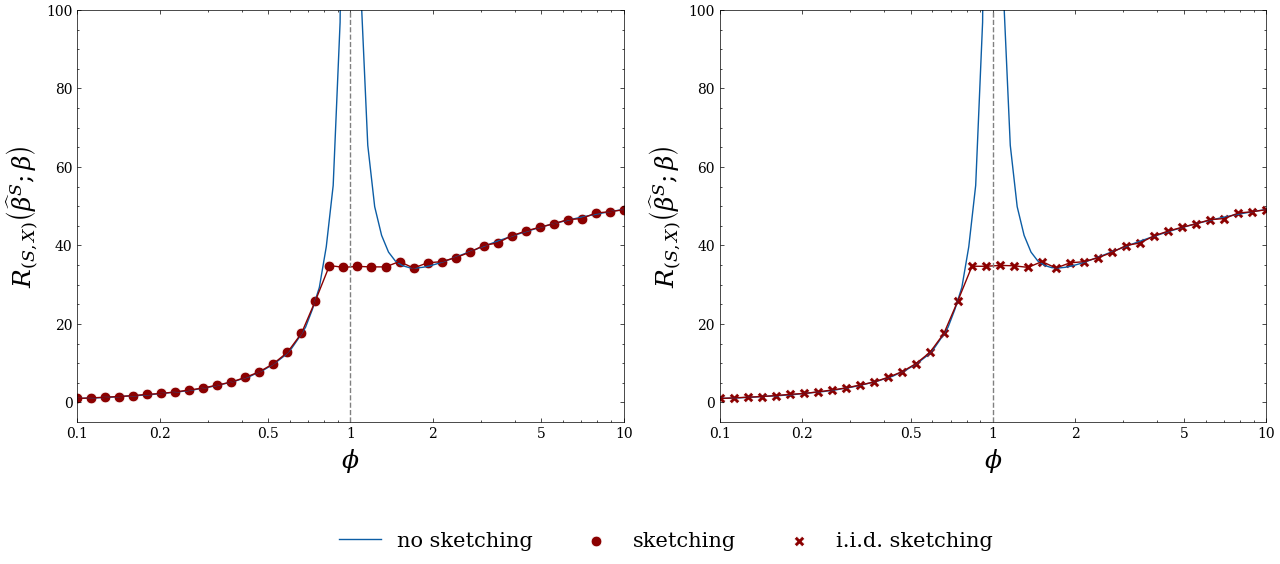

In [13]:
# Plot
ticks = [0.1, 0.2, 0.5, 1, 2, 5, 10]
labels = [i for i in ticks]

with plt.style.context(['science', 'no-latex', 'std-colors']):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))

    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('thm4.2_sym_lambda_S_orthogonal/snr2.0.json')
    ax[0] = sns.lineplot(x=phi_asy, y=ridgeless_risk, ax=ax[0], label="no sketching")
    ax[0] = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, ax=ax[0], s=60, color='darkred', label="sketching")
    ax[0] = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='darkred', ax=ax[0])


    ax[0].set_ylim(-5, 100)
    ax[0].set_xlim(0.1, 10)
    ax[0].axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
    #ax[0].set_title("Correlated features, orthogonal sketching matrix, SNR = 2.0")
    ax[0].set_xscale('log')
    ax[0].set(xticks = ticks, xticklabels = labels)
    ax[0].legend(loc='lower right')

    ax[0].set_ylabel(r"$R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$", fontsize=18)
    ax[0].set_xlabel(r"$\phi$", fontsize=18)


    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('thm4.2_sym_lambda_S_iid/snr2.0.json')
    ax[1] = sns.lineplot(x=phi_asy, y=ridgeless_risk, ax=ax[1])
    ax[1] = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, ax=ax[1], marker = 'X', s=60, color='darkred', label="i.i.d. sketching")
    ax[1] = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='darkred', ax=ax[1])
    

    ax[1].set_ylim(-5, 100)
    ax[1].set_xlim(0.1, 10)
    ax[1].axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
    #ax[1].set_title("Correlated features, i.i.d. sketching matrix, SNR = 2.0")
    ax[1].set_xscale('log')
    ax[1].set(xticks = ticks, xticklabels = labels)

    ax[1].set_ylabel(r"$R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$", fontsize=18)
    ax[1].set_xlabel(r"$\phi$", fontsize=18)
    ax[1].legend(loc='lower right')

    ax[0].get_legend().remove()
    ax[1].get_legend().remove()
    handles1, labels1 = ax[0].get_legend_handles_labels()
    handles2, labels2 = ax[1].get_legend_handles_labels()
    handles, labels = handles1 + handles2, labels1 + labels2
 
    #handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.52, -0.16), ncol = 4, prop={'size':15})
    plt.tight_layout()

    plt.savefig('figure4.pdf', dpi=400, facecolor='w', edgecolor='w', pad_inches=None)
    plt.show()